# Libraries and functions 

In [1]:
import sys
import cPickle as pickle
from scipy import stats
import matplotlib.backends.backend_pdf
import pandas as pd
import itertools

# Parameters to modify 

In [2]:
# Maximum number of models to be used. From ~1500 done, we will keep the best 1000
modelsKeep = 1000
# Base path where the folder branch is stored
basePath = '/home/julen/TADdyn/TADdyn_tutorial/'
# Define the orther of the cells for the ploting
orderCell = ['Ery', 'nCD4', 'Mon']
# Define the coloring options for each cell
colors = [(120/255., 94/255., 240/255.), 
          (254/255., 97/255., 0/255.),
          (220/255., 38/255., 127/255.)
         ]
# Wether to store figures in pdf or not
saveFig = True
# In which of the model clusters we will do the analysis
cluster = 1

## Path to files with coordinates to regulatory elements
# Locations in which we will assign promoters
promFile = basePath + 'additionaInput/gene_tss.txt'
# Locations in which we will assign enhancers or other regulatory elements
enhanFile = basePath + 'additionaInput/regElem.txt'
# Locations of the promoters or enhancers in which we will centre for the radial plot
interestFile = basePath + 'additionaInput/interest_distancePlot.txt'


# Optinal file with information about expression chip or other measures whose 
# location will be shown in the plots
# Format: Name Chromosome Coordinate Cell1 Cell2, Cell3, ...
# Example: Gene Chr TSS Ery nCD4 Mon  # Each Cell column has the expression value
# Of that cell in the gene that names the row
signalData = basePath + 'additionaInput/expressionData.txt'
# The signal thresshold associated to this files (if none leave it as None which
# will define 0 by default)
# Allowed lowest value is 0
thresshold = 0


# Run 

## Import additional libraries

In [3]:
sys.path.append(basePath + 'code')
import fileHandling
import plotting
import metrics

## Define new paths

In [4]:
# Output path for pickles and plots
outdata = basePath + 'outData/modelAnalysis/model_comparisons/distanceAnalysis/expressedElements/'
outplot = basePath + 'outPlot/modelAnalysis/model_comparisons/distanceAnalysis/expressedElements/'

# create folders
! mkdir -p {outdata}
! mkdir -p {outplot}

## Get model files and regions 

In [5]:
## Path were the models are stored
cells, regionsAll, models = fileHandling.getModelsPaths(basePath, ending='models')

## get regions
regiones = {}
# get info of the regions
for cell in cells:
    for regi in regionsAll:
        if not regi in regiones:
            
            regiones[regi] = fileHandling.getREgiInfo(basePath, regi, cell)
        else:
            infot = fileHandling.getREgiInfo(basePath, regi, cell)
            if infot != regiones[regi]:
                print('Region %s, cell %s has different parameters than previous cells')
                print('This code is not prepared to compare models with different length \
                      or resolution')

## Retrieve clustering data 

In [6]:
# If we ran this script with less models, will recover the previous clustering info
clustersPickle= basePath + 'outData/modelAnalysis/clustering/allClusterDict.pickle' 
with open(clustersPickle, "rb") as input_file:
    allClusters = pickle.load(input_file)
print('Recovering previous clustering data from:')
print(clustersPickle)

Recovering previous clustering data from:
/home/julen/TADdyn/TADdyn_tutorial/outData/modelAnalysis/clustering/allClusterDict.pickle


## Load additional input data 

In [7]:
enhAll, promAll, interAll = fileHandling.getElementCoordinates(regionsAll, regiones, enhanFile,
                          promFile, interestFile)

Enhancer HS-E1 was in same bin as a promoter (HBE1).     Bin position 294
Enhancer enh5 was in same bin as a promoter (STIM1,MIR4687,AC090587.1).     Bin position 12
Enhancer HS5 was in same bin as a promoter (OR51AB1P).     Bin position 299
Enhancer HS7 was in same bin as a promoter (OR51B4).     Bin position 301
Enhancer 3HS1 was in same bin as a promoter (OR51V1).     Bin position 281


## Load expression data 

In [8]:
# get the bins with expression
markers = fileHandling.createMarkers({}, {}, regiones, orderCell,
                 signalData, thresshold=thresshold)
# we just loaded signal, that in this case is expression
expresedBins = markers['Signal']

## Obtain distance distribution from interest elements

In [9]:
selected = []
selected += [(k, interAll[regi]['promoter'][k]['name']) 
             for k in interAll[regi]['promoter']]
selected += [(k, interAll[regi]['enhancer'][k]['name']) 
             for k in interAll[regi]['enhancer']]
selected = sorted(list(set(selected)))

In [10]:
distancesAll = metrics.getExpressedDistances(selected, expresedBins, regionsAll, models,
                                            modelsKeep, cluster, allClusters)

## Plot 

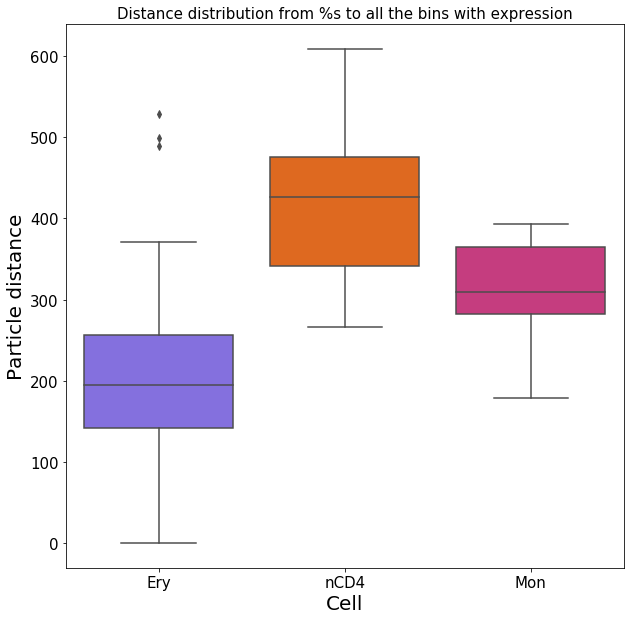

In [11]:
if saveFig == True:
    pdf = matplotlib.backends.backend_pdf.PdfPages(outplot + 'DistancesExpression.pdf')
else:
    pdf = None

plotting.expressionBoxplot(distancesAll, orderCell, colors, pdf=pdf)


## Get KS stats 

In [12]:
for genePos, geneName in distancesAll:
    print '-- %s --' %(geneName)
    for regi in distancesAll[(genePos, geneName)]:
        cells = []
        distances = []
        for cell in distancesAll[(genePos, geneName)][regi]:
            for dist in distancesAll[(genePos, geneName)][regi][cell]:
                cells += [cell]
                distances += [dist]
        dataframe = pd.DataFrame.from_dict({'cell':cells, 'Particle distances':distances})
        
        combs = itertools.combinations(orderCell, 2)
        for cell1, cell2 in combs:
            data1 = dataframe[dataframe['cell'] == cell1]['Particle distances']
            data2 = dataframe[dataframe['cell'] == cell2]['Particle distances']
            stat1 = stats.ks_2samp(data1, data2)
            print cell1, cell2, stat1

-- HBG2,AC104389.6 --
Ery nCD4 Ks_2sampResult(statistic=0.8186813186813187, pvalue=6.287019048761005e-09)
Ery Mon Ks_2sampResult(statistic=0.7142857142857143, pvalue=3.903755347896314e-07)
nCD4 Mon Ks_2sampResult(statistic=0.6538461538461539, pvalue=7.544330778452916e-06)
